In [1]:
import dask.dataframe as dd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
current_year = datetime.now().year

## Dask без параллельных вычислений

In [3]:
def load_data(filepath: str):
    """Загружаем CSV файл в Dask DataFrame"""
    data = dd.read_csv(filepath, assume_missing=True)
    data = data[["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", "price"
                       ]]
    return data

In [4]:
def preprocess_partition(batch):
    """Обрабатываем каждую партицию: дропаем пропуски и дубликаты, делаем новые фичи"""
    batch = batch.dropna()
    batch = batch.drop_duplicates()
    batch['mileage'] = np.log(batch['mileage'] + 1)
    
    return batch

In [5]:
def split_data(df: dd.DataFrame):
    """Разделяет данные на обучающую и тестовую выборки"""
    train_df = df.partitions[:-1]
    test_df = df.partitions[-1]
    return train_df, test_df

In [6]:
def train_catboost(filepath: str):
    """Функция обучения CatBoost по партициям"""
    # Параметры модели
    params = {
    'learning_rate': 0.15,
    'iterations': 300,
    'depth': 5,
    'random_state': 42
    }
    # Инициализируем модель
    model = CatBoostRegressor(
        **params, verbose=50
    )

    partitions = filepath.to_delayed()

    for i, partition in enumerate(partitions):
        partition = partition.compute()  # Загружаем партицию в память (compute только для текущей)
        partition = preprocess_partition(partition)  # Обрабатываем партицию

        # Категориальные признаки
        cat_features = [x for x in partition.columns if partition[x].dtype=='string[pyarrow]']
        partition[cat_features] = partition[cat_features].astype('category')

        feature_train = partition.drop(columns=["price"])
        target_train = partition["price"]
        log_target_train = np.log(target_train + 1)

        if i == 0:
            model.fit(feature_train, log_target_train, cat_features=cat_features)  # Первый батч - обучаем модель с нуля
        else:
            model.fit(feature_train, log_target_train, cat_features=cat_features, 
                      init_model=model)  # Следующие партиции - дообучаем модель

    return model



In [7]:
def predict_in_partitions(model, test_df):
    """Функция для прогнозов на тестовых партициях"""
    predictions = []
    actuals = []

    for partition in test_df.to_delayed():
        batch = partition.compute()
        batch = preprocess_partition(batch)
        X_batch = batch.drop(columns=["price"])
        y_batch = batch["price"]

        y_pred = model.predict(X_batch)
        # Обратное преобразование (экспоненцирование)
        y_pred = np.exp(y_pred) - 1  # Отменяем логарифмирование (экспоненцируем)
        predictions.append(y_pred)
        actuals.append(y_batch)

    return np.concatenate(predictions), np.concatenate(actuals)

In [8]:
def calculate_metrics(y_pred, y_true):
    """Функция для расчета метрик"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = (np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Оценка тестового множества модели CatBoost:")
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('R2: {:.2f}'.format(r2))

In [9]:
file = "dataset_with_electro.csv"  # Путь к исходным данным

df = load_data(file)
train_df, test_df = split_data(df)

# Обучаем модель
print("Обучаем CatBoost на обучающих данных...")
model = train_catboost(train_df)

y_preds, y_true = predict_in_partitions(model, test_df)

Обучаем CatBoost на обучающих данных...
0:	learn: 0.9613491	total: 163ms	remaining: 48.7s
50:	learn: 0.3274178	total: 1.57s	remaining: 7.67s
100:	learn: 0.3013636	total: 2.9s	remaining: 5.71s
150:	learn: 0.2870771	total: 4.11s	remaining: 4.05s
200:	learn: 0.2780886	total: 5.26s	remaining: 2.59s
250:	learn: 0.2713570	total: 6.4s	remaining: 1.25s
299:	learn: 0.2658868	total: 7.54s	remaining: 0us
0:	learn: 0.2909473	total: 8.47ms	remaining: 2.53s
50:	learn: 0.2854235	total: 1.19s	remaining: 5.81s
100:	learn: 0.2808251	total: 2.3s	remaining: 4.53s
150:	learn: 0.2751441	total: 3.45s	remaining: 3.4s
200:	learn: 0.2694914	total: 4.58s	remaining: 2.26s
250:	learn: 0.2650603	total: 5.72s	remaining: 1.12s
299:	learn: 0.2605652	total: 6.83s	remaining: 0us
0:	learn: 0.2864070	total: 24ms	remaining: 7.19s
50:	learn: 0.2736155	total: 1.17s	remaining: 5.71s
100:	learn: 0.2675970	total: 2.29s	remaining: 4.52s
150:	learn: 0.2618448	total: 3.45s	remaining: 3.41s
200:	learn: 0.2574853	total: 4.63s	remain

In [10]:
# Оцениваем модель
print("Оцениваем модель на тестовых данных...")
calculate_metrics(y_preds, y_true)

Оцениваем модель на тестовых данных...
Оценка тестового множества модели CatBoost:
MSE: 149029763260.08
RMSE: 386043.73
MAE: 114078.18
MAPE: 0.20
R2: 0.89


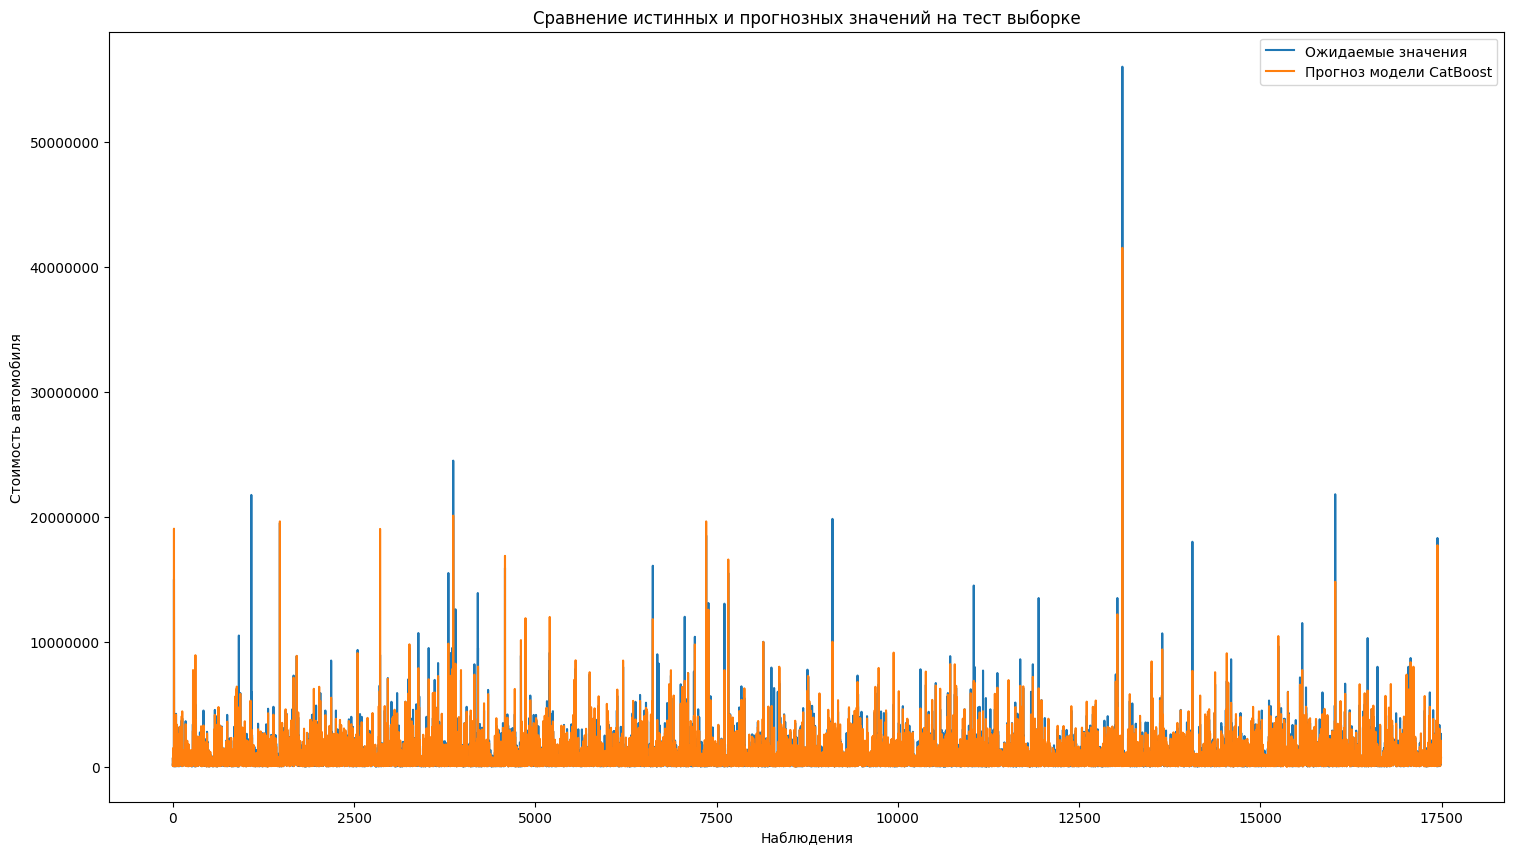

In [11]:
plt.figure(figsize=(18,10))
plt.title("Сравнение истинных и прогнозных значений на тест выборке")
plt.plot(y_true, label = 'Ожидаемые значения')
plt.plot(y_preds, label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [12]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs"
                       ]).sort_values()

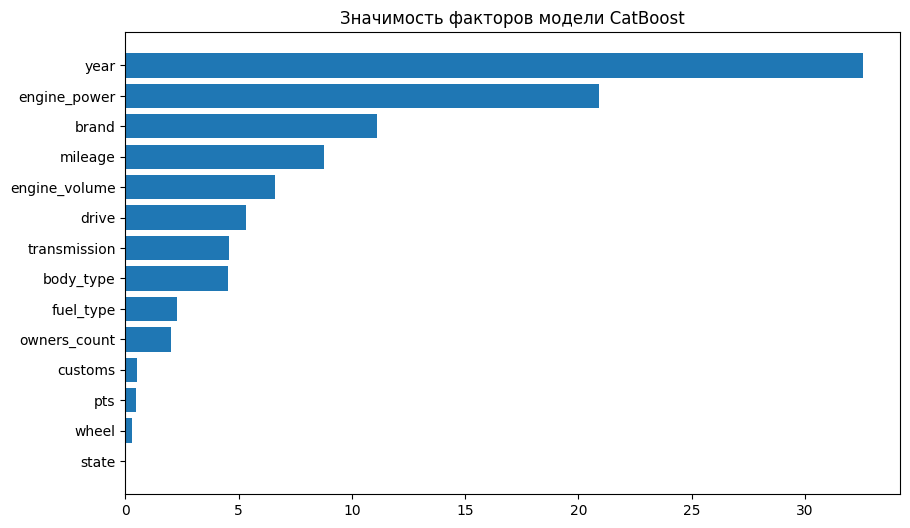

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()

## Dask с параллельными вычислений

In [5]:
import dask.dataframe as dd
import dask
import numpy as np
from catboost import CatBoostRegressor

def load_data(filepath: str):
    """Загружаем CSV файл в Dask DataFrame"""
    data = dd.read_csv(filepath, assume_missing=True)
    data = data[["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs", "price"
                       ]]
    return data

def split_data(df: dd.DataFrame):
    """Разделяет данные на обучающую и тестовую выборки"""
    train_df = df.partitions[:-1]
    test_df = df.partitions[-1]
    return train_df, test_df

def preprocess_partition(batch):
    """Обрабатываем каждую партицию"""
    batch = batch.dropna().drop_duplicates()
    batch['mileage'] = np.log(batch['mileage'] + 1)
    return batch

def train_partition(partition, params):
    """Функция обучения модели на одной партиции"""
    partition = preprocess_partition(partition)

    cat_features = [x for x in partition.columns if partition[x].dtype == 'string[pyarrow]']
    partition[cat_features] = partition[cat_features].astype('category')

    feature_train = partition.drop(columns=["price"])
    target_train = np.log(partition["price"] + 1)  # Логарифмируем

    model = CatBoostRegressor(**params)
    model.fit(feature_train, target_train, cat_features=cat_features)
    
    return model

def train_catboost(filepath: str):
    """Обучение CatBoost параллельно по партициям"""
    params = {'learning_rate': 0.15, 'iterations': 600, 'depth': 5, 'random_state': 42}

    partitions = filepath.to_delayed()
    trained_models = [dask.delayed(train_partition)(part, params) for part in partitions]
    
    models = dask.compute(*trained_models)  # Параллельное обучение на всех партициях
    
    return models  # Можно усреднять предсказания нескольких моделей или выбирать лучшую

def predict_partition(model, partition):
    """Прогноз на одной партиции"""
    partition = preprocess_partition(partition)
    X_batch = partition.drop(columns=["price"])
    y_batch = partition["price"]
    
    y_pred = np.exp(model.predict(X_batch)) - 1  # Обратное логарифмирование
    return y_pred, y_batch

def predict_in_partitions(models, test_df):
    """Функция предсказания с несколькими моделями"""
    partitions = test_df.to_delayed()
    
    predictions = [dask.delayed(predict_partition)(models[i % len(models)], part) for i, part in enumerate(partitions)]
    results = dask.compute(*predictions)
    
    pred_values, actual_values = zip(*results)
    
    return np.concatenate(pred_values), np.concatenate(actual_values)


In [6]:
file = "dataset_with_electro.csv"  # Путь к исходным данным

df = load_data(file)
train_df, test_df = split_data(df)

# Обучаем модель
print("Обучаем CatBoost на обучающих данных...")
model = train_catboost(train_df)

y_preds, y_true = predict_in_partitions(model, test_df)

Обучаем CatBoost на обучающих данных...
0:	learn: 0.9557976	total: 167ms	remaining: 1m 40s
0:	learn: 0.9655938	total: 104ms	remaining: 1m 2s
0:	learn: 0.9682136	total: 165ms	remaining: 1m 38s
0:	learn: 0.9569563	total: 95.4ms	remaining: 57.1s
0:	learn: 0.9565616	total: 126ms	remaining: 1m 15s
0:	learn: 0.9571915	total: 122ms	remaining: 1m 12s
0:	learn: 0.9525946	total: 117ms	remaining: 1m 10s
0:	learn: 0.9461024	total: 116ms	remaining: 1m 9s
0:	learn: 0.9613491	total: 171ms	remaining: 1m 42s
0:	learn: 0.9542837	total: 106ms	remaining: 1m 3s
0:	learn: 0.9645190	total: 139ms	remaining: 1m 23s
0:	learn: 0.9524737	total: 156ms	remaining: 1m 33s
0:	learn: 0.9631668	total: 175ms	remaining: 1m 44s
0:	learn: 0.9536732	total: 170ms	remaining: 1m 41s
0:	learn: 0.9597236	total: 209ms	remaining: 2m 5s
0:	learn: 0.9645927	total: 198ms	remaining: 1m 58s
1:	learn: 0.8631362	total: 224ms	remaining: 1m 7s
1:	learn: 0.8590899	total: 153ms	remaining: 45.9s
1:	learn: 0.8560596	total: 176ms	remaining: 52.6

In [7]:
def calculate_metrics(y_pred, y_true):
    """Функция для расчета метрик"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = (np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Оценка тестового множества модели CatBoost:")
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('R2: {:.2f}'.format(r2))

In [8]:
# Оцениваем модель
print("Оцениваем модель на тестовых данных...")
calculate_metrics(y_preds, y_true)

Оцениваем модель на тестовых данных...
Оценка тестового множества модели CatBoost:
MSE: 341216555536.51
RMSE: 584137.45
MAE: 123397.69
MAPE: 0.20
R2: 0.74


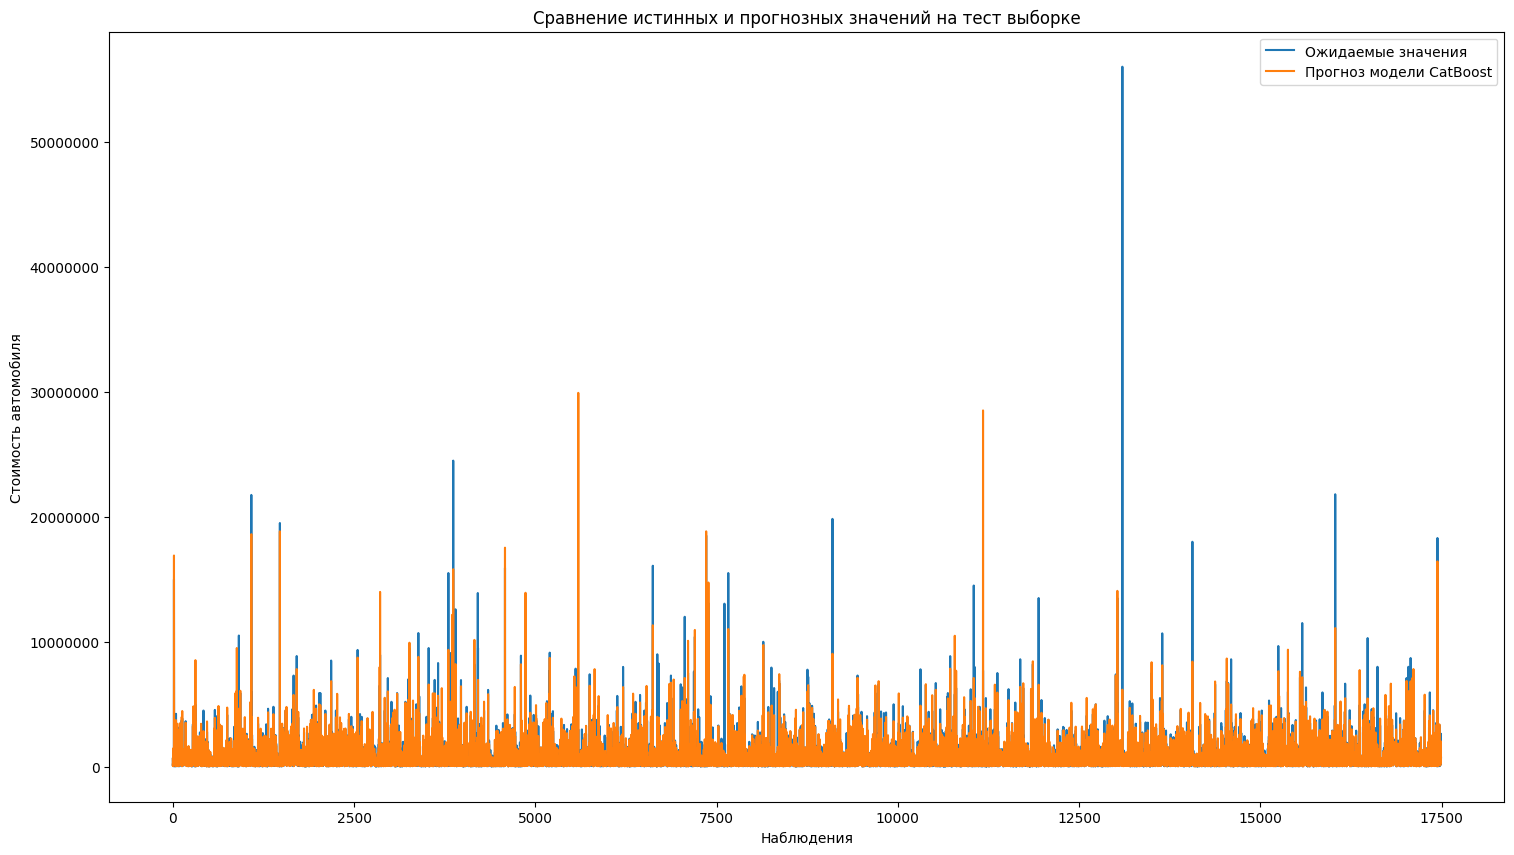

In [9]:
plt.figure(figsize=(18,10))
plt.title("Сравнение истинных и прогнозных значений на тест выборке")
plt.plot(y_true, label = 'Ожидаемые значения')
plt.plot(y_preds, label = 'Прогноз модели CatBoost')
plt.xlabel('Наблюдения')
plt.ylabel('Стоимость автомобиля')
plt.ticklabel_format(style='plain')
plt.legend()
plt.show()

In [15]:
importances = model[1].get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=["brand", "year", "mileage", "body_type", "fuel_type",
                       "engine_volume", "engine_power", "transmission","drive", "wheel",
                       "state", "owners_count", "pts", "customs"
                       ]).sort_values()

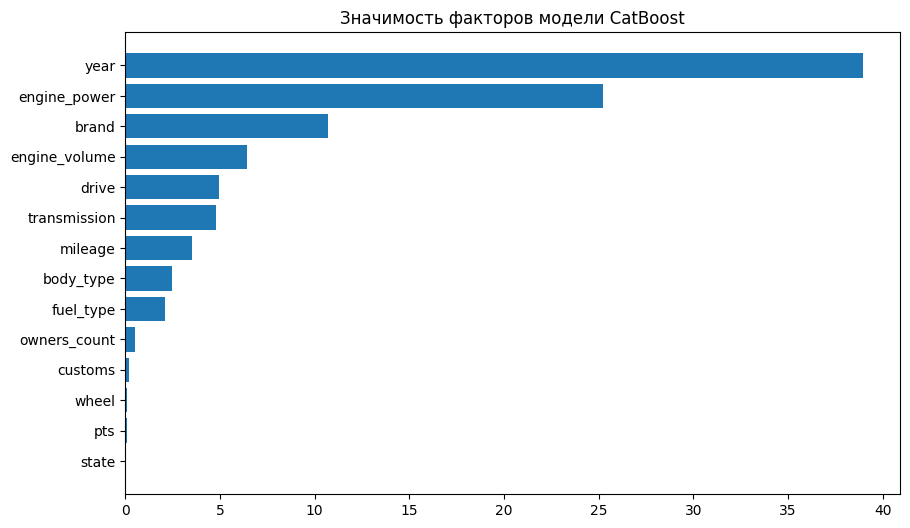

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()